# SINA: Project Movie Recommendation

# ML pipeline Python and NEO4J

The inspiration was gotten from https://anaconda.org/maxdemarzi/motifs/notebook


There are more information on **Chapter 8 of the free Graph Algorithms Book**:

https://neo4j.com/graph-algorithms-book/?ref=maxdemarzi

It is available at **UTS Library** as well.

This notebook has the following sections:

**1. Settings:** indicates how to configure the system to develop with Python and NEO4J.

**2. Connection with NEO4J:** check if the connection from Python to NEO4J is working.

**3. Exploratory data analysis (EDA):** shows some plots that describes the daa behaviour.

**4. Prepare the data and run the model:**

    4.1. Definition of functions to generate graph data features and additional data features from the data, and to define the neural network structure.
    
    4.2. Instantiation of functions to prepare data and generate the neural network.
    
    4.3. Evaluation of the model using RMSE.
    
    

## 1. Settings

Install NEO4J Desktop: 

I've created a database version **Neo4j 3.4.14**. This allows me to use the **GRAPH LIBRARY** from NEO4J. Even though is deprecated I prefer use it because the newer version of graph algorithms **Graph Data Science Library** has mostly all of them in **ALPHA phase** (Indicates that the algorithm is experimental and might be changed or removed at any time). (https://neo4j.com/docs/graph-data-science/current/algorithms/)

Install Anaconda: https://www.anaconda.com/distribution/


### 1.1. Configurations NEO4J
Add apoc and algo plugins to neo4j/plugins directory.

In neo4j.conf:

                    apoc.import.file.enabled=true

                    apoc.import.file.use_neo4j_config=true

                    dbms.security.procedures.unrestricted=apoc.*,algo.*

### 1.2. Scripts NEO4J (CYPHER)

In Neo4j:

#### 1.2.1. Create the schema:

Use file **import.cypher**

#### 1.2.2. Create graph features:

Use file: **cypher_features.cypher**



## 2. Establish a connection to NEO4J

This code allows to test if the connection with NEO4J graph database is OK.

In [1]:
# just verification of directory
import os
os.getcwd()

'/home/claudia/SINA'

In [2]:
# just verification of python version
!python --version

Python 3.7.7


In [31]:
# import essential packages
from py2neo import Graph
import pandas as pd
from numpy.random import randint

import matplotlib.pyplot as plt
import numpy as np

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from datetime import datetime as dt
import numpy as np

# Import the relevant packages of tensorflow and classes
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Dense, LeakyReLU, Dropout
from tensorflow.keras import regularizers
from tensorflow import random

# set the SEED to have the same results on every moment
random.set_seed(168)
np.random.seed(168)

In [4]:
# get the initial connection to NEO4J
graph = Graph("bolt://localhost:7687", auth=("neo4j", "123"))

In [5]:
# check the number of MOVIES on NEO4J
graph.run("match (n:MOVIE) return count(n)").to_data_frame()

,count(n)
0,1682


In [6]:
# check the number of USERS on NEO4J
graph.run("match (n:USER) return count(n)").to_data_frame()

,count(n)
0,943


## 3. Exploratory data analysis

This section will traverse through the data using some plots. The aim is to find insights that can improve the feature engineering of the predictive model.

In [7]:
# Get data of MOVIES, USERS and RATED from NEO4J
df_true_ratings = graph.run('''MATCH (user:USER)-[r:RATED]->(movie:MOVIE)
RETURN user.id AS user_id, movie.id AS movie_id, r.rating AS rating,
                user.age as age, user.gender AS gender, 
                user.occupation as occupation, user.zipcode AS zipcode''').to_data_frame()

In [8]:
# Configure matplotlib
%matplotlib inline

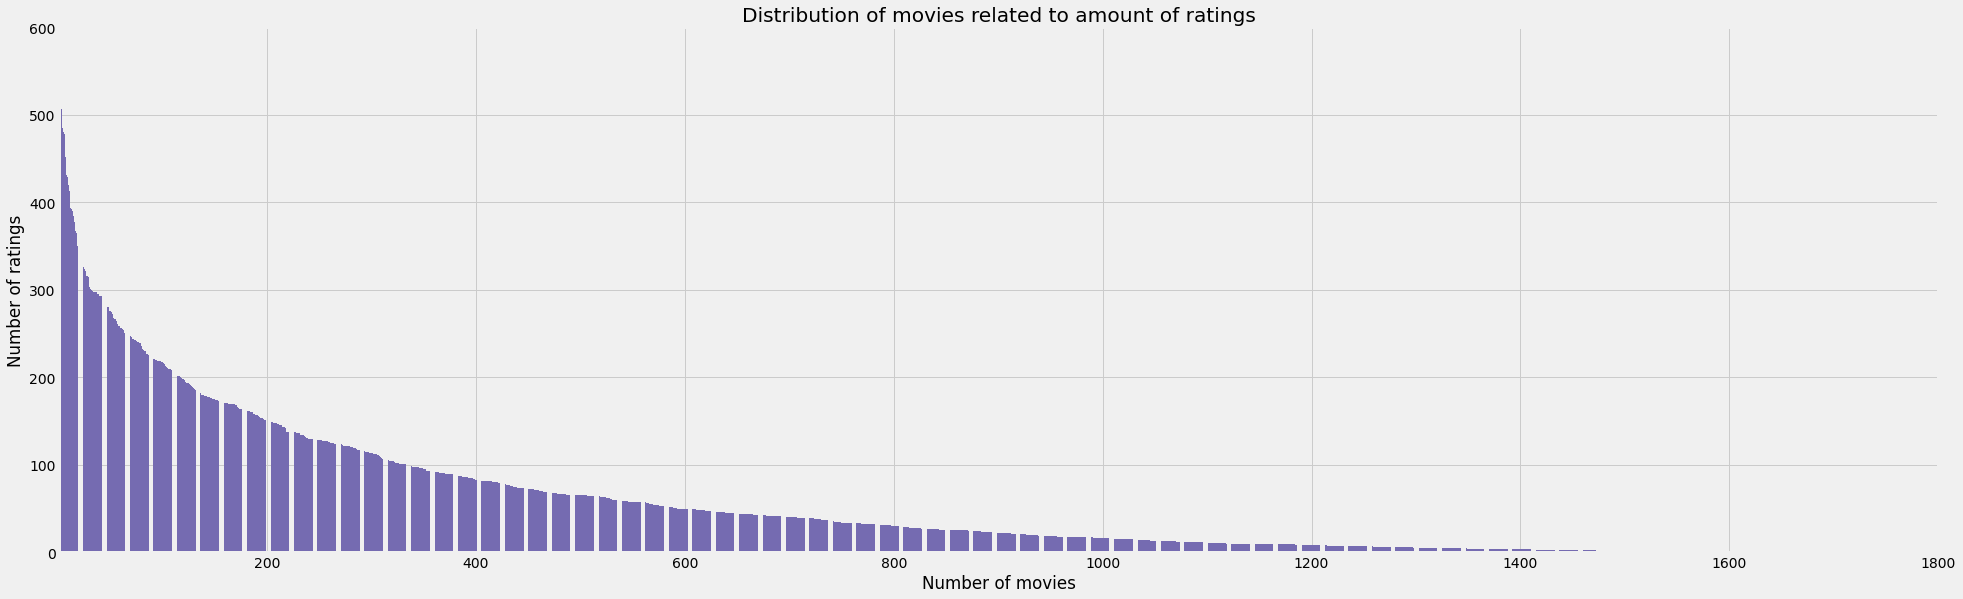

In [9]:
# Plot of distribution of ratings among movies

plt.style.use('fivethirtyeight')
# Plot ratings vs items
df_ri = df_true_ratings[['rating', 'movie_id']]
df_plot_ri = df_ri.groupby(['movie_id']).size().reset_index(name='counts')

 
# Sort values of movies according to the counts value
df_plot_ri = df_plot_ri.sort_values('counts', ascending=False)
height = df_plot_ri['counts']
bars = df_plot_ri['movie_id']
y_pos = np.arange(len(bars))

plt.figure(figsize=(30, 9))

# Setting color
plt.bar(y_pos, height, color = '#756bb1')
 
# Title and axis labels
plt.title('Distribution of movies related to amount of ratings')
plt.xlabel('Number of movies')
plt.ylabel('Number of ratings')
 
# Limits for the Y axis
plt.ylim(0,600)
plt.xlim(1,1800)

# Show graphic
plt.show()


The figure shows a distribution of ratings among the movies available in the MovieLens 100k dataset. That indicates a small number of movies have most of the user's evaluations. Therefore, the dataset is highly skewed.

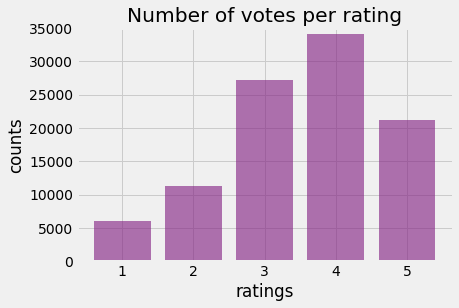

In [10]:
# Plot of ratings and number of votes

plt.style.use('fivethirtyeight')
# Plot ratings vs items
df_ri = df_true_ratings[['rating']]
df_plot_ri = df_ri.groupby(['rating']).size().reset_index(name='counts')

counts = df_plot_ri['counts']
bars =  df_plot_ri['rating']
y_pos = np.arange(len(bars))

# Create bars and choose color
plt.bar(y_pos, counts, color = (0.5,0.1,0.5,0.6))

# Add title and axis names
plt.title('Number of votes per rating')
plt.xlabel('ratings')
plt.ylabel('counts')

# Limits for the Y axis
plt.ylim(0,35000)

# Create names
plt.xticks(y_pos, bars)
# Show graphic
plt.show()

The figure shows which rating has the most and least number of votes on the MovieLens 100k dataset.

## 4. Prepare data and run the model

### 4.1. Definition of functions

In [11]:
def generate_initial_dataset(cycle, condition):
    '''
    Function for creating a training dataset from MovieLens partitions
    -------------------------------------------------------------------
    Params
    ======
    Input: 
        * cycle that is the number of iteration
        * condition that is to select a Training or Testing group
    
    Output: dataset training or testing with the basic information of USERS and MOVIES and their edge RATED
    '''
    query = "MATCH (user:USER)-[r:RATED]->(movie:MOVIE) WHERE r.Test_" + str(cycle) + \
                " " + str(condition) + ''' 'Train' 
                RETURN user.id AS node_user, movie.id AS node_movie, r.rating AS rating, 
                user.age as age, user.gender AS gender, 
                user.occupation as occupation, user.zipcode AS zipcode'''

    data_df = graph.run(query).to_data_frame()
    data_df = data_df.replace(np.nan, 0)
    return data_df

In [12]:
def generate_graph_features_dataset(cycle, condition):
    '''
    Function for generating graph features based on the edge RATED
    -------------------------------------------------------------------
    Params
    ======
    Input: 
        * cycle that is the number of iteration
        * condition that is to select a Training or Testing group
    
    Output: dataset with the graph features
    '''
    
    query = "MATCH (p1:USER)-[r:RATED]->(p2:MOVIE) WHERE  r.Test_" + str(cycle) + \
                " " + str(condition) + '''  'Train'
                RETURN algo.linkprediction.commonNeighbors(p1, p2, {relationshipQuery: "RATED"}) AS commonNeighbors,
                algo.linkprediction.preferentialAttachment(p1, p2, {relationshipQuery: "RATED"}) AS prefAttachment,
                algo.linkprediction.totalNeighbors(p1, p2, {relationshipQuery: "RATED"}) AS totalNeighbours,
                p1.id AS node_user,
                p2.id AS node_movie'''
    
    graph_features_df = graph.run(query).to_data_frame()     
    return graph_features_df

In [13]:
def age_band(df):
    if df['age'] <= 18:
        val = 'under_18'
    elif df['age'] > 18 and df['age'] <= 29:
        val = '18_to_29'
    elif df['age'] > 29 and df['age'] <= 44:
        val = '30_to_44'
    else:
        val = '45_and_over'
    return val

In [14]:
def generate_additional_features_dataset(df):
    '''
    Function for generating additional features based on the exploratory data analysis
    -----------------------------------------------------------------------------------
    Params
    ======
    Input: dataset (training and testing data)
    
    Output: dataset with new added features
    '''
    dataset = df
    df_ri = dataset[['rating', 'node_movie']]
    df1 = df_ri.groupby(['node_movie'], as_index=False).mean()
    df1.rename(columns={'rating':'item_mean_rating'}, inplace=True)

    # the new feature if added to the main dataset
    dataset = pd.merge(dataset,
                 df1[['node_movie', 'item_mean_rating']],
                 on='node_movie', 
                 how='left')
    # It is created a new feature which is the mean of the rating per genre and movie
    df_ri = dataset[['rating', 'node_movie', 'gender']]
    df1 = df_ri.groupby(['node_movie', 'gender'], as_index=False).mean()
    df1.rename(columns={'rating':'gender_item_mean_rating'},  inplace=True)
    # the new feature is added to the main dataset
    dataset = pd.merge(dataset,
                 df1,
                 on=['node_movie', 'gender'], 
                 how='left')

    dataset['age_band'] = dataset.apply(age_band, axis=1)
    
    # It is created a new feature which is the mean of the rating per movie and age
    df_ri = dataset[['rating', 'node_movie', 'age_band']]
    df1 = df_ri.groupby(['node_movie', 'age_band'], as_index=False).mean()
    df1.rename(columns={'rating':'age_band_item_mean_rating'}, inplace=True)
    # the new feature is added to the main dataset
    dataset = pd.merge(dataset,
                 df1,
                 on=['node_movie', 'age_band'], 
                 how='left')


    add_features_df = dataset[['node_user', 'node_movie','rating','age','item_mean_rating','gender_item_mean_rating',
                                 'age_band_item_mean_rating']]
    
    return add_features_df

In [58]:
def create_model():
    '''
    Function for creating the neural network 
    -----------------------------------------------------------------------------------
    Params
    ======
    Input: empty
    
    Output: model neural network
    '''  
    
    model = tf.keras.Sequential()

    model.add(Dense(16, activation='relu', input_shape=(7,)))
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Dropout(0.5))
    #model.add(Dense(512, activation='relu'))
    #model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    

    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    model.summary()
    
    return model

In [16]:
def calculate_elapsed_time(start, end):
    '''
    Function for creating the neural network 
    -----------------------------------------------------------------------------------
    Params
    ======
    Input: dataset
    
    Output: dataset
    '''   
    # Calculate elapsed time
    elapsedTime = end - start
    duration_in_s = elapsedTime.total_seconds()
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("Time between times: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

###  4.2. Data preparation

In [17]:
# this section has the following tasks:
# 1. For each group defined into MovieLens having training and testing datasets:
# 1.1. Read training and testing data
# 1.2. Generate graph features using NEO4J
# 1.3. Generate additional features from the basic dataset
# 1.4. Run the neural network
# 1.5. Evaluate the model

EPOCHS = int(10)

storage_history = {}
storage_pred = {}
storage_rmse = {}

storage_scaled_X_train = {}
storage_scaled_X_test = {}
storage_y_train = {}
storage_y_test = {}    


for i in range(5):
    
    start = dt.now() # check the initial time
    cycle = i + 1
    train_df = generate_initial_dataset(cycle, '=')
    test_df = generate_initial_dataset(cycle, '<>')
    
    train_gf_df = generate_graph_features_dataset(cycle, '=')
    test_gf_df = generate_graph_features_dataset(cycle, '<>')
    
    train_df = generate_additional_features_dataset(train_df)
    test_df = generate_additional_features_dataset(test_df)
    
    train_df = pd.merge(train_df,train_gf_df, how='inner', on=['node_movie', 'node_user'])
    test_df = pd.merge(test_df,test_gf_df, how='inner', on=['node_movie', 'node_user'])
    
    y_train = train_df['rating']
    y_test =  test_df['rating']
    X_train = train_df[['commonNeighbors','prefAttachment','totalNeighbours', 
                                'age','item_mean_rating','gender_item_mean_rating',
                                 'age_band_item_mean_rating']]
    X_test = test_df[['commonNeighbors','prefAttachment','totalNeighbours', 
                                 'age','item_mean_rating','gender_item_mean_rating',
                                 'age_band_item_mean_rating']]
    
    scaled_X_train = scale(X_train)
    scaled_X_test = scale(X_test)
    
    np.argwhere(np.isnan(scaled_X_train))
    
    scaled_X_train[np.isnan(scaled_X_train)] = 1e-10
    scaled_X_test[np.isnan(scaled_X_test)] = 1e-10
    
    storage_scaled_X_train[cycle] = scaled_X_train
    storage_scaled_X_test[cycle] = scaled_X_test
    storage_y_train[cycle] = y_train
    storage_y_test[cycle] = y_test
    
    end = dt.now() # store the final time
    calculate_elapsed_time(start, end)
    

Time between times: 0 days, 0 hours, 3 minutes and 39 seconds
Time between times: 0 days, 0 hours, 3 minutes and 36 seconds
Time between times: 0 days, 0 hours, 3 minutes and 27 seconds
Time between times: 0 days, 0 hours, 3 minutes and 44 seconds
Time between times: 0 days, 0 hours, 3 minutes and 48 seconds


In [59]:
for i in range(5):
    
    start = dt.now() # check the initial time
    cycle = i + 1
    
    model_nn = create_model()
    
    scaled_X_train = storage_scaled_X_train[cycle]
    y_train = storage_y_train[cycle]
    scaled_X_test = storage_scaled_X_test[cycle]
    
    history = model_nn.fit(scaled_X_train, y_train, epochs = int(EPOCHS), validation_split = 0.2)
    pred=model_nn.predict(scaled_X_test,verbose=0)
    
    storage_history[cycle] = history
    storage_pred[cycle]= pred
    storage_rmse[cycle] = np.sqrt(mean_squared_error(pred, y_test))
    
    end = dt.now() # store the final time
    calculate_elapsed_time(start, end)
    s = 'The value of RMSE is ' + str(storage_rmse[cycle]) + ', Iteration ' + repr(cycle) 
    print(s)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 16)                128       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 16)                272       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 16)              

###  4.3. Evaluate the model

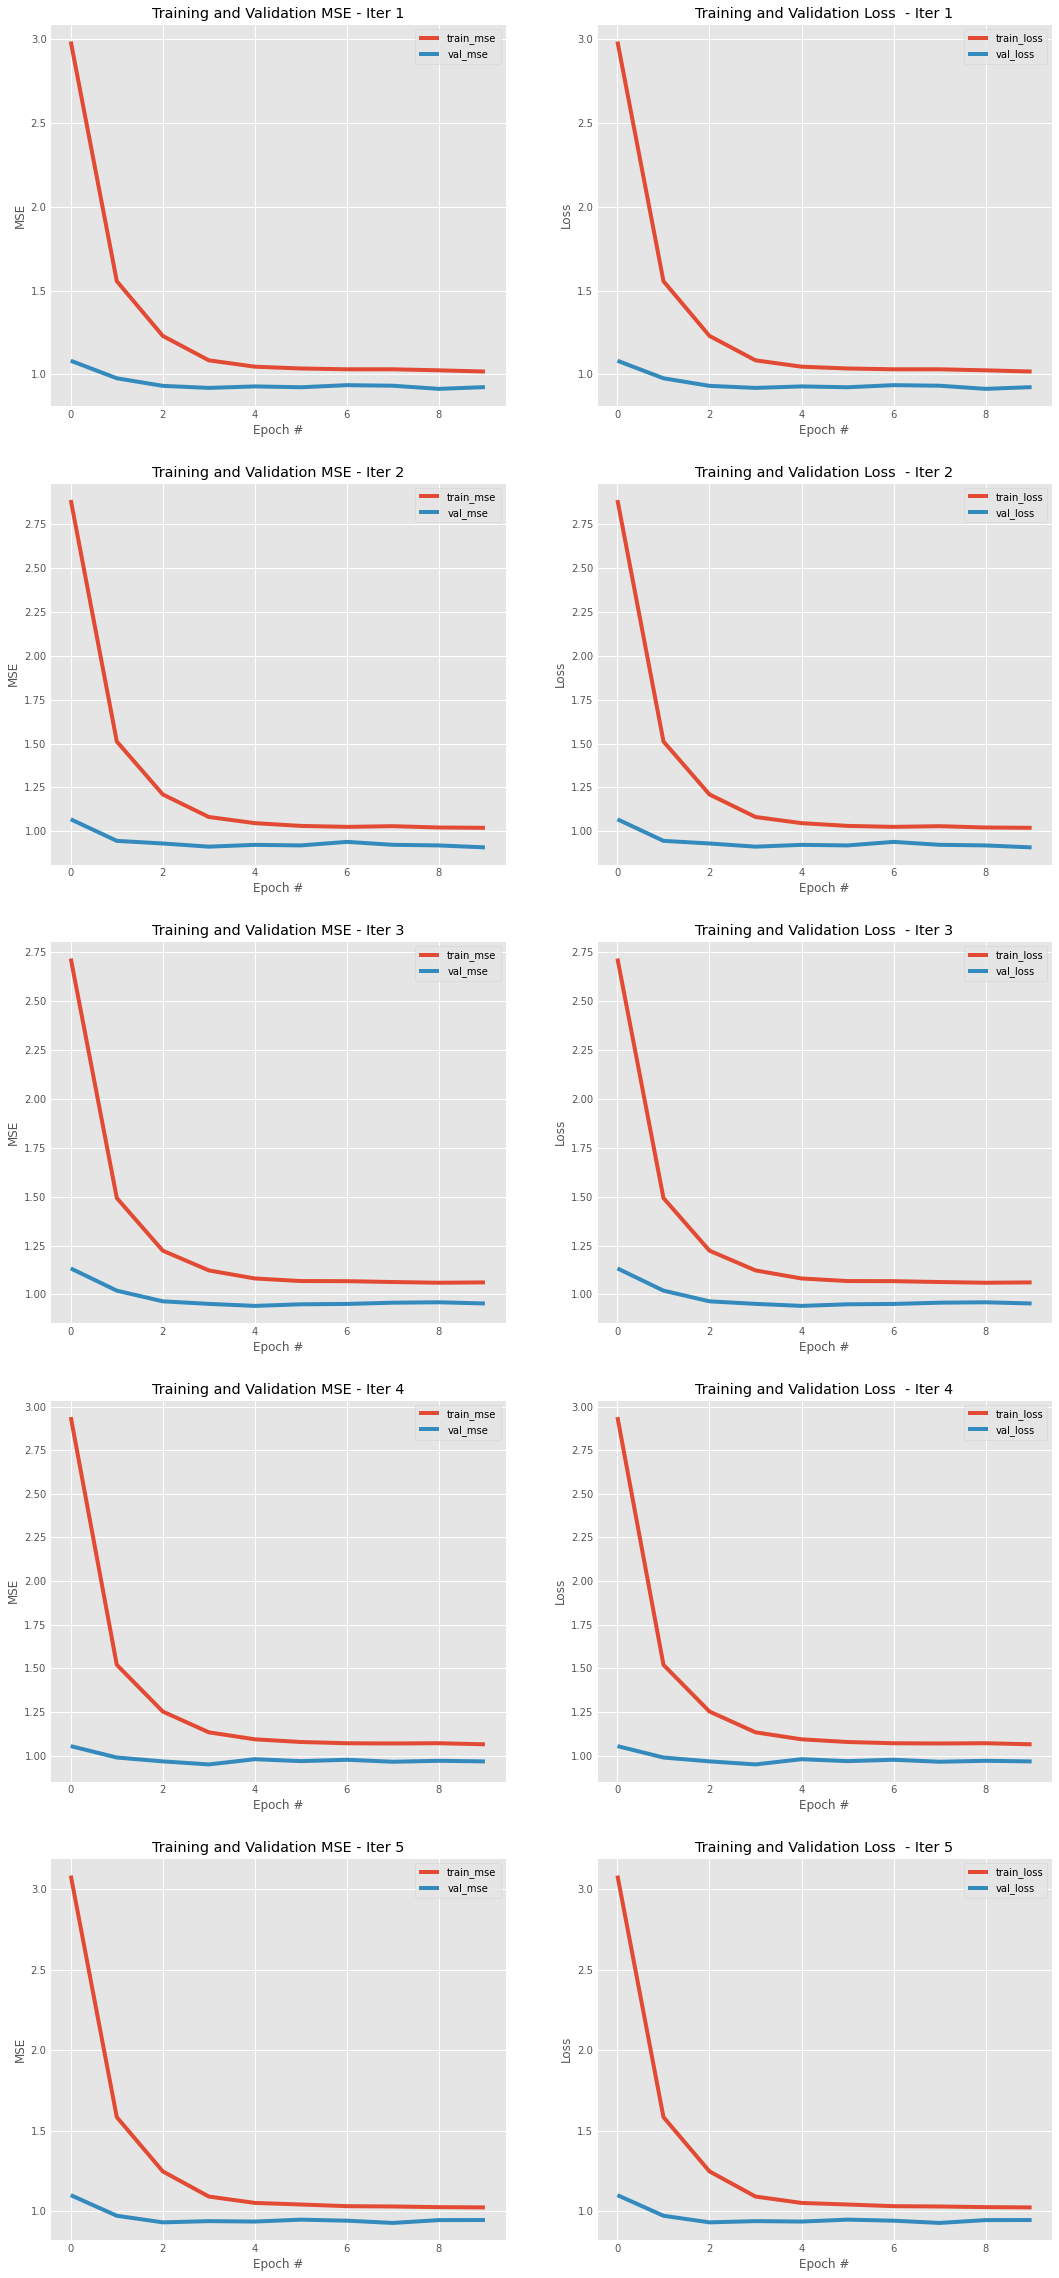

In [60]:
plt.style.use("ggplot")
plt.figure(figsize=(16, 38))

plot = int(0)

for i in range(5):
    idx = i+1

    hty = storage_history[idx]

    plot = plot + 1
    plt.subplot(5, 2, plot)
    plt.plot(np.arange(0, EPOCHS), hty.history["mse"], label="train_mse")
    plt.plot(np.arange(0, EPOCHS), hty.history["val_mse"], label="val_mse")
    plt.title("Training and Validation MSE - Iter " + str(idx))
    plt.xlabel("Epoch #")
    plt.ylabel("MSE")
    plt.legend(loc='upper right')
    
    plot = plot + 1
    plt.subplot(5, 2, plot)
    plt.plot(np.arange(0, EPOCHS), hty.history["loss"], label="train_loss")
    plt.plot(np.arange(0, EPOCHS), hty.history["val_loss"], label="val_loss")
    plt.title("Training and Validation Loss  - Iter " + str(idx))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')


plt.show()


In [61]:
 for i in range(5):
    idx = i+1
    value_rmse = "Value RMSE: " + str(storage_rmse[idx]) + " Iteration: " + str(idx)
    
    print(value_rmse)

Value RMSE: 1.1872118812241033 Iteration: 1
Value RMSE: 1.1956947833530773 Iteration: 2
Value RMSE: 1.1866354470195475 Iteration: 3
Value RMSE: 1.1706029505009525 Iteration: 4
Value RMSE: 0.9392610987740224 Iteration: 5
